In [119]:
from itertools import cycle
from collections import Counter
import time
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_fscore_support

In [120]:
df = pd.read_csv('dataset/Grades.csv')

In [121]:
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

for col in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts().to_string())

Dataset shape: (397, 25)

Data types:
university           object
sex                  object
age                   int64
address              object
motherEducation       int64
fatherEducation       int64
motherJob            object
fatherJob            object
reason               object
travelTime            int64
studyTime             int64
failures              int64
universitySupport    object
paid                 object
higher               object
internet             object
romantic             object
freeTime              int64
goOut                 int64
Dalc                  int64
Walc                  int64
absences              int64
EPSGrade              int64
DSGrade               int64
finalGrade            int64
dtype: object

Unique values in university:
university
PR    350
CM     47

Unique values in sex:
sex
F    209
M    188

Unique values in address:
address
U    308
R     89

Unique values in motherJob:
motherJob
other       142
services    103
at_home      60
te

In [122]:
def preprocess_data(df):
    df_processed = df.copy()
    
    columns_with_other = ['reason', 'fatherJob', 'motherJob']
    
    for col in columns_with_other:
        df_processed[col] = df_processed[col].replace('other', np.nan)
    
    for column in df_processed.columns:
        if df_processed[column].dtype == 'object':
            most_frequent = df_processed[column].mode()[0]
            df_processed[column].fillna(most_frequent, inplace=True)
        else:
            median_val = df_processed[column].median()
            df_processed[column].fillna(median_val, inplace=True)
    
    return df_processed

df_cleaned = preprocess_data(df)

C:\Users\itspa\AppData\Local\Temp\ipykernel_18548\251177047.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[column].fillna(most_frequent, inplace=True)
C:\Users\itspa\AppData\Local\Temp\ipykernel_18548\251177047.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [123]:
def encode_categorical_features(df):
    df_encoded = df.copy()
    
    binary_cols = ['universitySupport', 'paid', 'higher', 'internet', 'romantic']
    for col in binary_cols:
        df_encoded[col] = df_encoded[col].map({'yes': 1, 'no': 0})
    
    nominal_cols = ['university', 'sex', 'address', 'reason']
    df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True)
    
    education_cols = ['motherEducation', 'fatherEducation']
    for col in education_cols:
        df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')
    
    job_mapping = {
        'teacher': 5,
        'health': 4,
        'services': 3,
        'at_home': 2,
        'other': 1
    }
    
    job_cols = ['motherJob', 'fatherJob']
    for col in job_cols:
        df_encoded[col] = df_encoded[col].map(job_mapping)
    
    return df_encoded

df_processed = encode_categorical_features(df_cleaned)

In [124]:
correlation_matrix = df_processed.corr()

print("\nCorrelations with final grade:")
print(correlation_matrix['finalGrade'].sort_values(ascending=False).head(10))


Correlations with final grade:
finalGrade         1.000000
DSGrade            0.905238
EPSGrade           0.802676
motherEducation    0.220783
higher             0.179180
fatherEducation    0.155256
motherJob          0.134210
internet           0.114395
address_U          0.113765
paid               0.108440
Name: finalGrade, dtype: float64


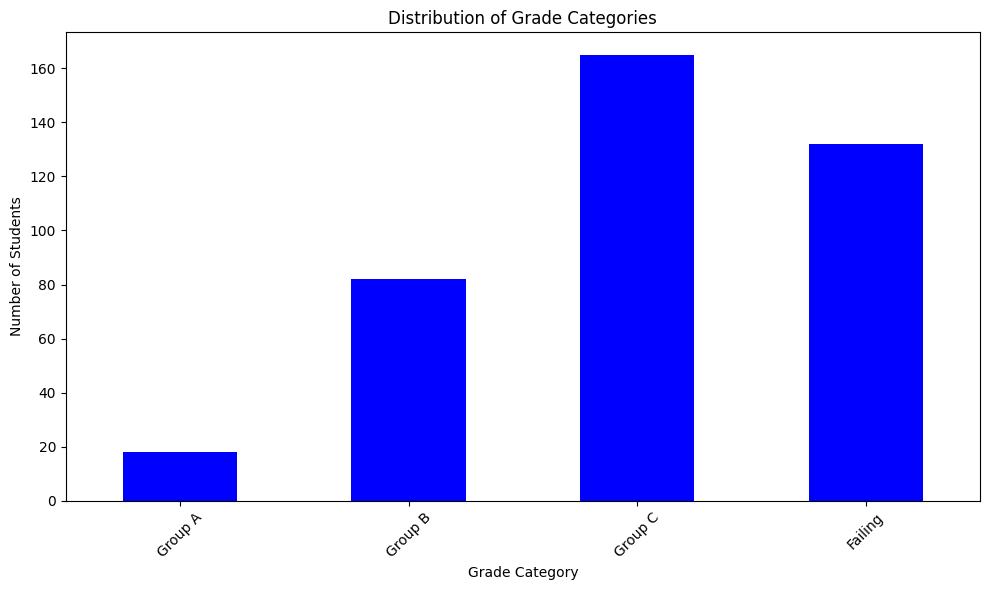

In [125]:
def categorize_grades(df):
    df_categorized = df.copy()
    
    conditions = [
        (df_categorized['finalGrade'] > 17),
        (df_categorized['finalGrade'] >= 14) & (df_categorized['finalGrade'] <= 17),
        (df_categorized['finalGrade'] >= 10) & (df_categorized['finalGrade'] < 14),
        (df_categorized['finalGrade'] < 10)
    ]
    
    categories = ['Group A', 'Group B', 'Group C', 'Failing']
    
    df_categorized['grade_category'] = np.select(conditions, categories, default='Unknown')
    
    df_categorized['grade_category'] = pd.Categorical(
        df_categorized['grade_category'], 
        categories=categories,
        ordered=True
    )
    
    return df_categorized

df_categorized = categorize_grades(df_processed)

plt.figure(figsize=(10, 6))
df_categorized['grade_category'].value_counts(sort=False).plot(
    kind='bar', 
    color='blue'
)
plt.title('Distribution of Grade Categories')
plt.xlabel('Grade Category')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [126]:
X = df_categorized.drop(['finalGrade', 'grade_category'], axis=1)
y = df_categorized['grade_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True).sort_index())

X_train shape: (317, 25)
X_test shape: (80, 25)
y_train shape: (317,)
y_test shape: (80,)

Class distribution in training set:
grade_category
Group A    0.044164
Group B    0.208202
Group C    0.416404
Failing    0.331230
Name: proportion, dtype: float64

Class distribution in testing set:
grade_category
Group A    0.0500
Group B    0.2000
Group C    0.4125
Failing    0.3375
Name: proportion, dtype: float64


In [127]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

def engineer_features(X):
    X_new = X.copy()
    X_new['study_efficiency'] = X['studyTime'] / (X['freeTime'] + 1)
    X_new['social_balance'] = X['goOut'] / (X['studyTime'] + 1)
    X_new['total_alcohol'] = X['Dalc'] + X['Walc']
    X_new['log_absences'] = np.log1p(X['absences'])
    X_new['parent_edu_avg'] = (X['motherEducation'] + X['fatherEducation']) / 2
    return X_new

X_train_engineered = engineer_features(X_train_scaled)
X_test_engineered = engineer_features(X_test_scaled)

Naive Bayes Accuracy: 0.6375

Classification Report:
              precision    recall  f1-score   support

     Failing       0.85      0.81      0.83        27
     Group A       0.50      1.00      0.67         4
     Group B       0.42      0.69      0.52        16
     Group C       0.70      0.42      0.53        33

    accuracy                           0.64        80
   macro avg       0.62      0.73      0.64        80
weighted avg       0.68      0.64      0.64        80



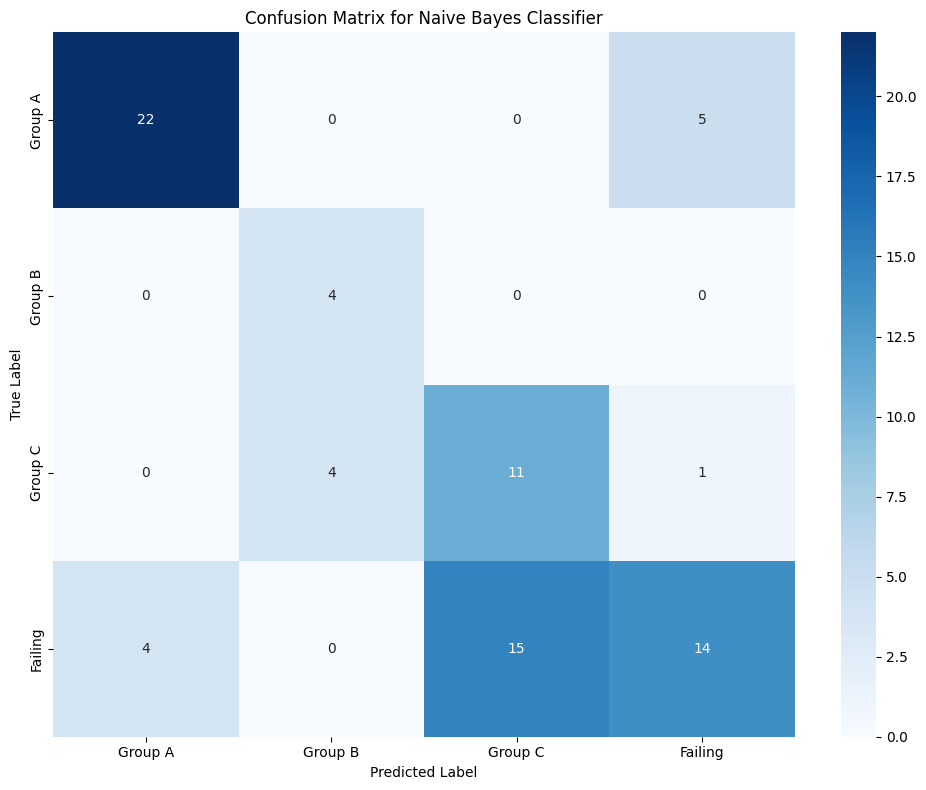

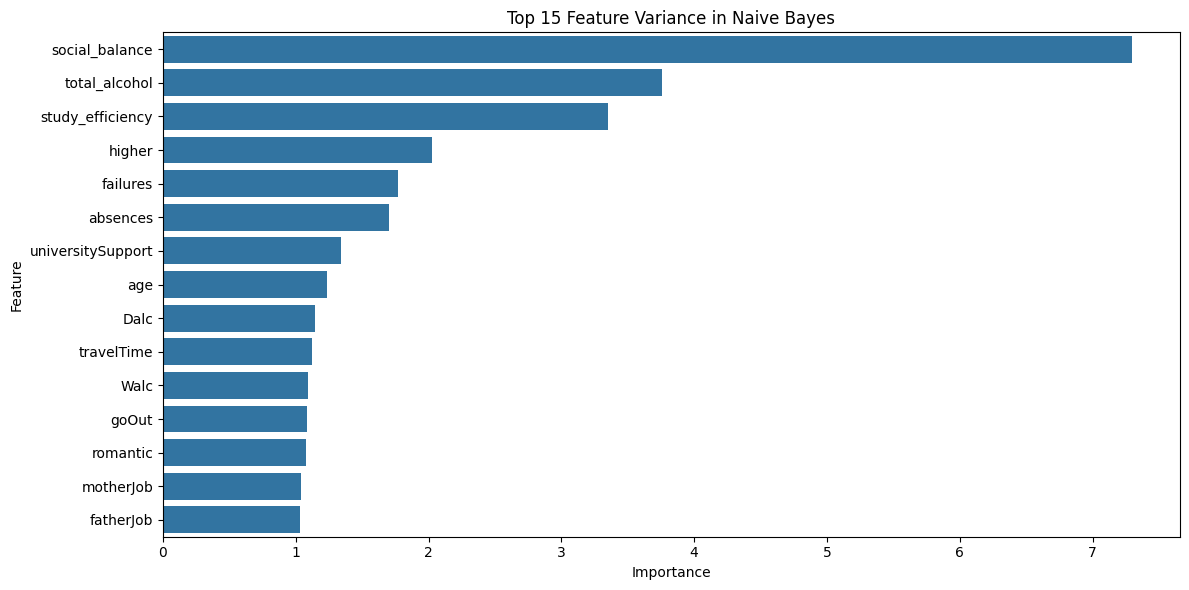


Precision: 0.6839
Recall: 0.6375
F1 Score: 0.6362


In [128]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_engineered, y_train)

y_pred = nb_classifier.predict(X_test_engineered)

accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Group A', 'Group B', 'Group C', 'Failing'],
            yticklabels=['Group A', 'Group B', 'Group C', 'Failing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.tight_layout()
plt.show()

def plot_feature_importance(classifier, feature_names):
    feature_importance = classifier.var_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance[0]
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Feature Variance in Naive Bayes')
    plt.tight_layout()
    plt.show()

plot_feature_importance(nb_classifier, X_train_engineered.columns)

y_prob = nb_classifier.predict_proba(X_test_engineered)

lb = LabelBinarizer()
lb.fit(y_train)
y_test_binary = lb.transform(y_test)
y_prob_binary = lb.transform(y_pred)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Decision Tree Accuracy: 0.8375

Classification Report:
              precision    recall  f1-score   support

     Failing       0.88      0.85      0.87        27
     Group A       0.75      0.75      0.75         4
     Group B       0.92      0.69      0.79        16
     Group C       0.79      0.91      0.85        33

    accuracy                           0.84        80
   macro avg       0.84      0.80      0.81        80
weighted avg       0.85      0.84      0.84        80



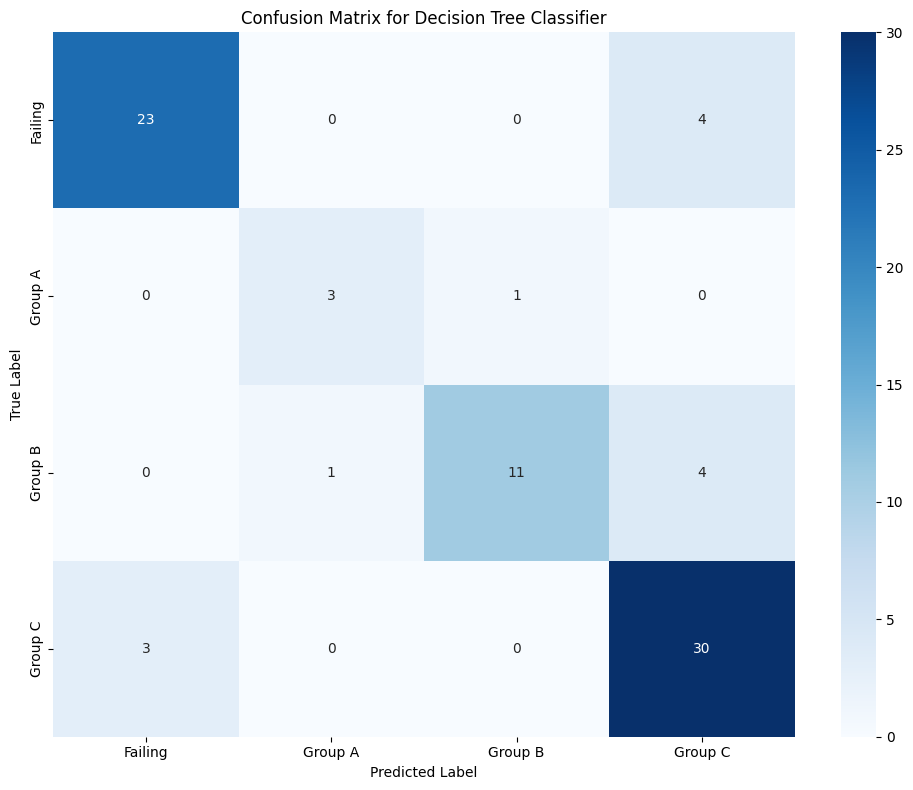

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Optimized Decision Tree Accuracy: 0.8625

Classification Report for Optimized Tree:
              precision    recall  f1-score   support

     Failing       0.86      0.93      0.89        27
     Group A       0.67      1.00      0.80         4
     Group B       1.00      0.69      0.81        16
     Group C       0.85      0.88      0.87        33

    accuracy                           0.86        80
   macro avg       0.85      0.87      0.84        80
weighted avg       0.88      0.86      0.86        80



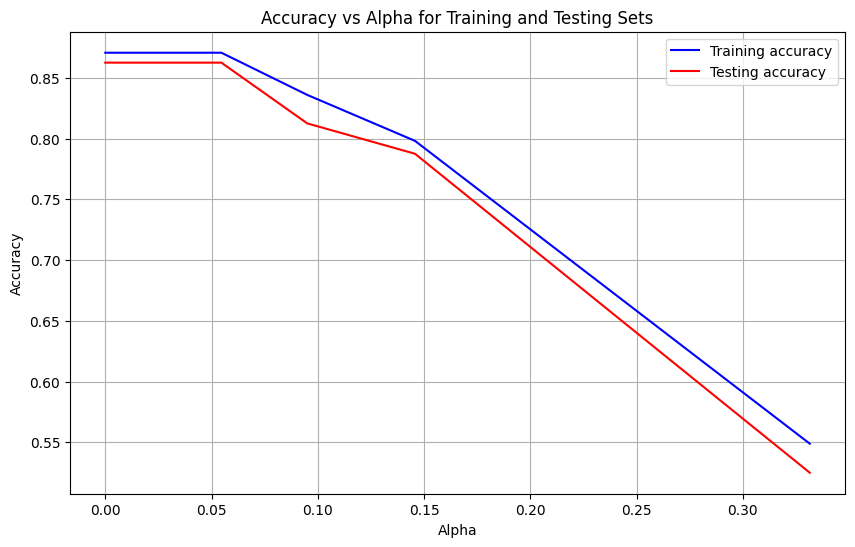

Optimal alpha: 0.000000

Final Pruned Decision Tree Accuracy: 0.8625

Classification Report for Final Pruned Tree:
              precision    recall  f1-score   support

     Failing       0.86      0.93      0.89        27
     Group A       0.67      1.00      0.80         4
     Group B       1.00      0.69      0.81        16
     Group C       0.85      0.88      0.87        33

    accuracy                           0.86        80
   macro avg       0.85      0.87      0.84        80
weighted avg       0.88      0.86      0.86        80



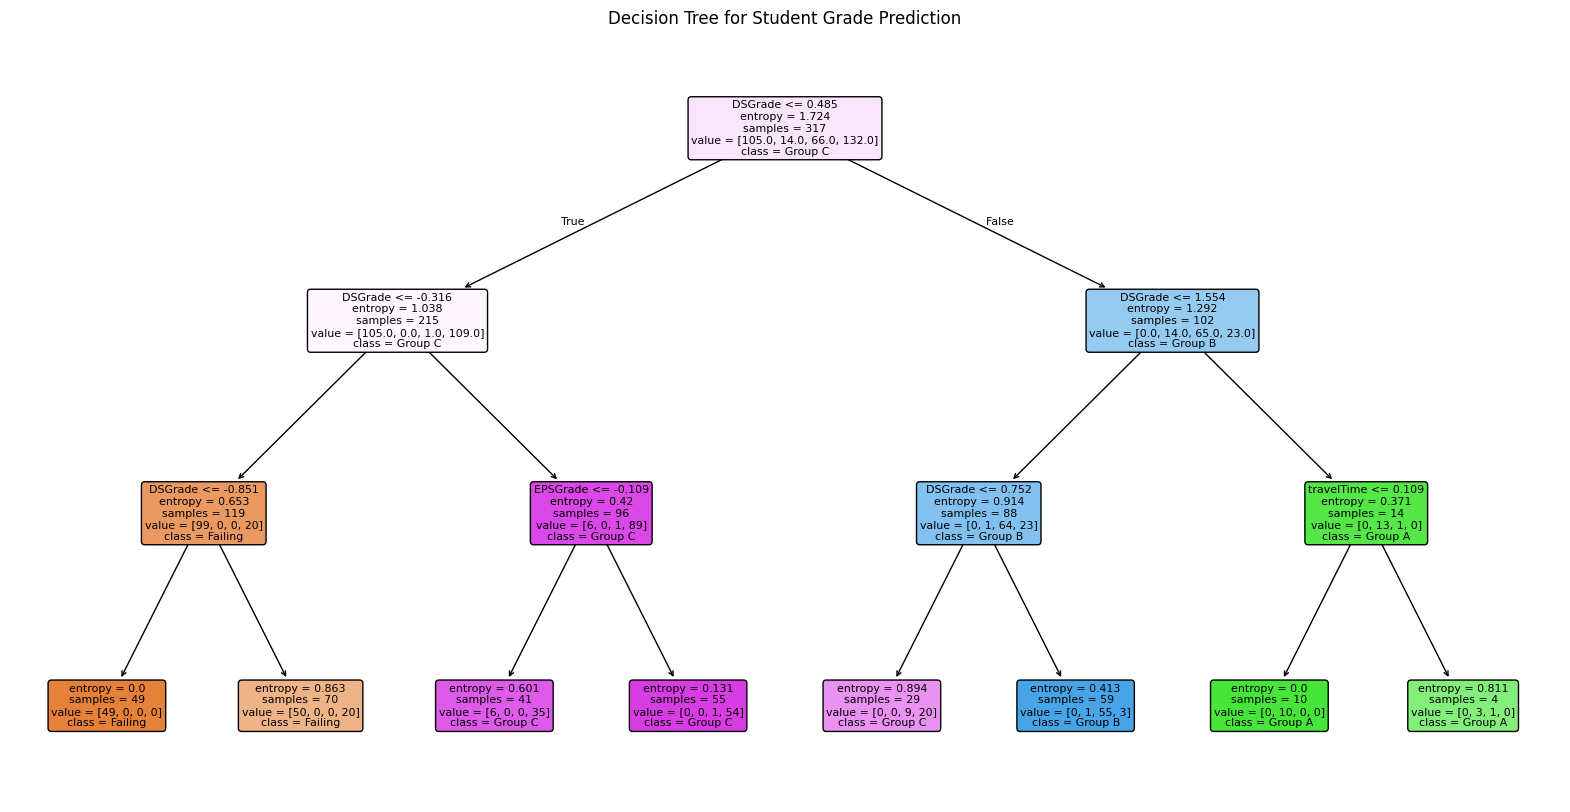

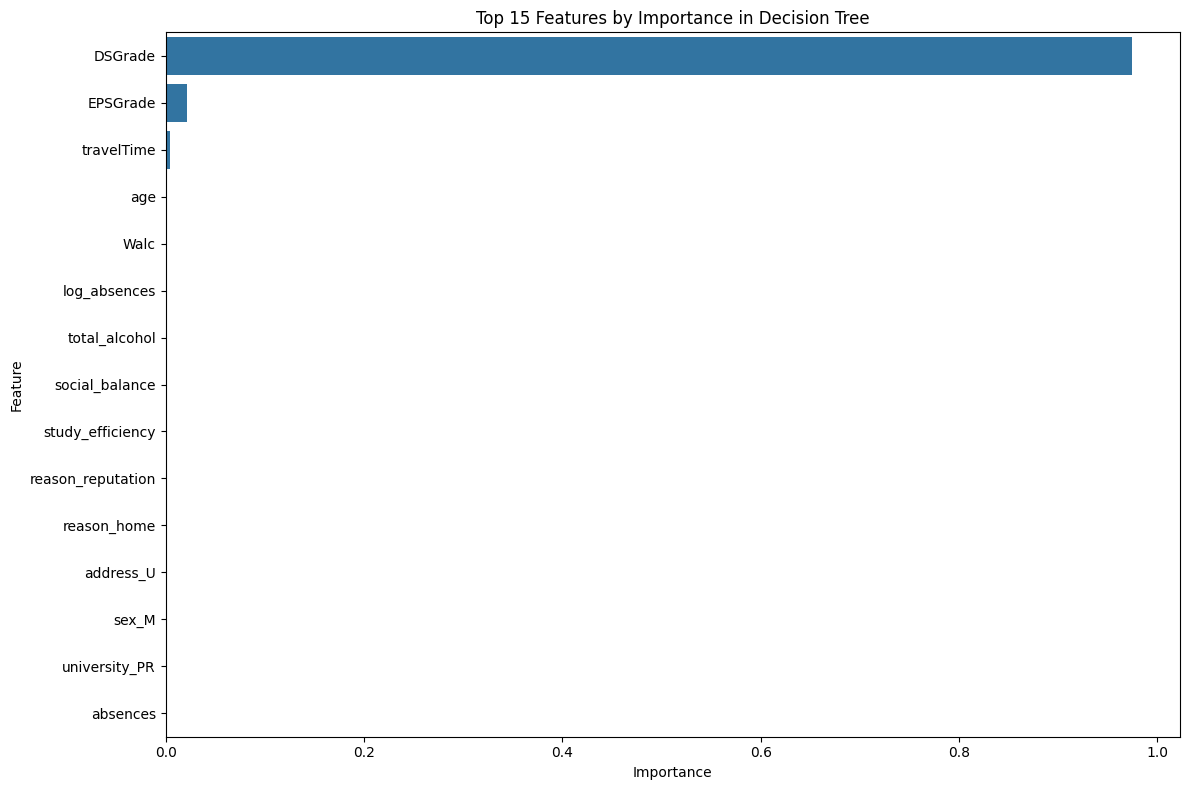


Top 10 Most Important Features:
              Feature  Importance
19            DSGrade    0.974002
18           EPSGrade    0.021129
5          travelTime    0.004869
0                 age    0.000000
16               Walc    0.000000
28       log_absences    0.000000
27      total_alcohol    0.000000
26     social_balance    0.000000
25   study_efficiency    0.000000
24  reason_reputation    0.000000

Number of features with zero importance: 27


In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_engineered, y_train)

y_pred_dt = dt_classifier.predict(X_test_engineered)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_classifier.classes_,
            yticklabels=dt_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.tight_layout()
plt.show()

param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_engineered, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_dt_classifier = grid_search.best_estimator_

y_pred_best_dt = best_dt_classifier.predict(X_test_engineered)

accuracy_best_dt = accuracy_score(y_test, y_pred_best_dt)
print(f"\nOptimized Decision Tree Accuracy: {accuracy_best_dt:.4f}")

print("\nClassification Report for Optimized Tree:")
print(classification_report(y_test, y_pred_best_dt))

path = best_dt_classifier.cost_complexity_pruning_path(X_train_engineered, y_train)
ccp_alphas = path.ccp_alphas

pruned_clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, **best_params)
    clf.fit(X_train_engineered, y_train)
    pruned_clfs.append(clf)

train_scores = [clf.score(X_train_engineered, y_train) for clf in pruned_clfs]
test_scores = [clf.score(X_test_engineered, y_test) for clf in pruned_clfs]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], train_scores[:-1], 'b-', label='Training accuracy')
plt.plot(ccp_alphas[:-1], test_scores[:-1], 'r-', label='Testing accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha for Training and Testing Sets')
plt.legend()
plt.grid(True)
plt.show()

optimal_idx = np.argmax(test_scores[:-1])
optimal_alpha = ccp_alphas[optimal_idx]
print(f"Optimal alpha: {optimal_alpha:.6f}")

final_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha, **best_params)
final_dt.fit(X_train_engineered, y_train)

y_pred_final = final_dt.predict(X_test_engineered)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Pruned Decision Tree Accuracy: {accuracy_final:.4f}")

print("\nClassification Report for Final Pruned Tree:")
print(classification_report(y_test, y_pred_final))

plt.figure(figsize=(20, 10))
plot_tree(  final_dt, 
            feature_names=X_train_engineered.columns, 
            class_names=final_dt.classes_,
            filled=True, 
            rounded=True, 
            max_depth=3)
plt.title("Decision Tree for Student Grade Prediction")
plt.show()

dot_data = export_graphviz(
    final_dt,
    out_file=None,
    feature_names=X_train_engineered.columns,
    class_names=final_dt.classes_,
    filled=True,
    rounded=True,
    max_depth=4 
)

graph = graphviz.Source(dot_data)

feature_importances = final_dt.feature_importances_
feature_names = X_train_engineered.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features by Importance in Decision Tree')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

zero_importance = importance_df[importance_df['Importance'] == 0]
print(f"\nNumber of features with zero importance: {len(zero_importance)}")

Random Forest Baseline Accuracy: 0.8875

Classification Report:
              precision    recall  f1-score   support

     Failing       0.92      0.89      0.91        27
     Group A       1.00      0.50      0.67         4
     Group B       0.88      0.88      0.88        16
     Group C       0.86      0.94      0.90        33

    accuracy                           0.89        80
   macro avg       0.91      0.80      0.84        80
weighted avg       0.89      0.89      0.88        80



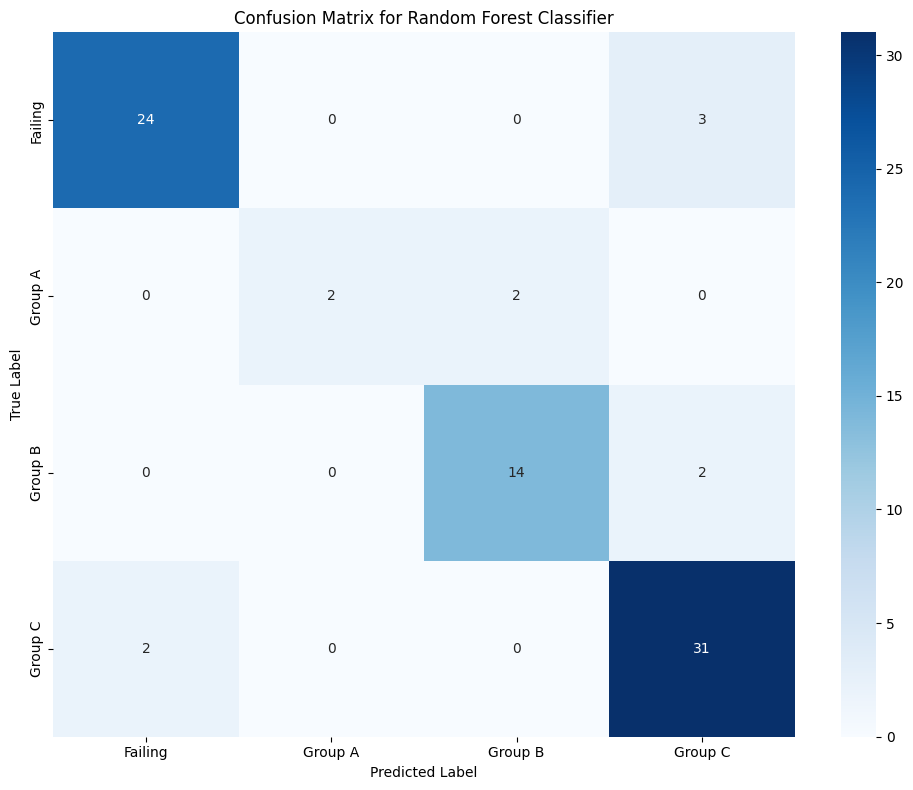

Starting RandomizedSearchCV...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearchCV complete.

Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 63}

Optimized Random Forest Accuracy: 0.8625

Classification Report for Optimized Random Forest:
              precision    recall  f1-score   support

     Failing       0.86      0.93      0.89        27
     Group A       0.67      1.00      0.80         4
     Group B       1.00      0.69      0.81        16
     Group C       0.85      0.88      0.87        33

    accuracy                           0.86        80
   macro avg       0.85      0.87      0.84        80
weighted avg       0.88      0.86      0.86        80



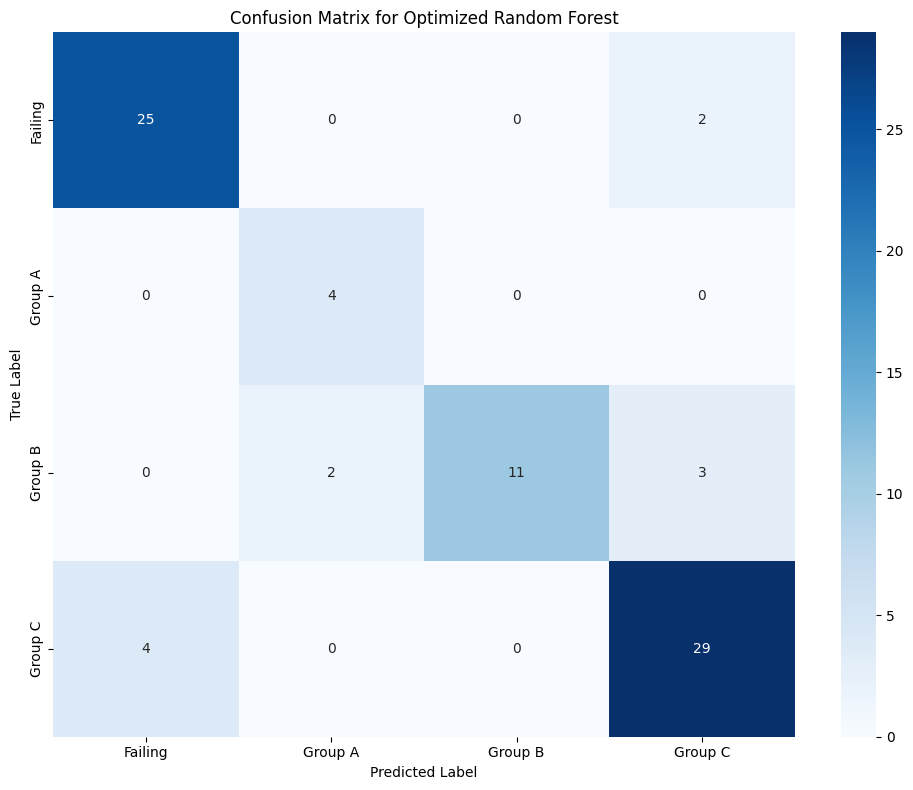

Model Performance Comparison:
                       Model  Accuracy  Precision  Recall  F1 Score
0                Naive Bayes    0.6375   0.683942  0.6375  0.636208
1     Decision Tree (Pruned)    0.8625   0.876120  0.8625  0.861392
2  Random Forest (Optimized)    0.8625   0.876120  0.8625  0.861392


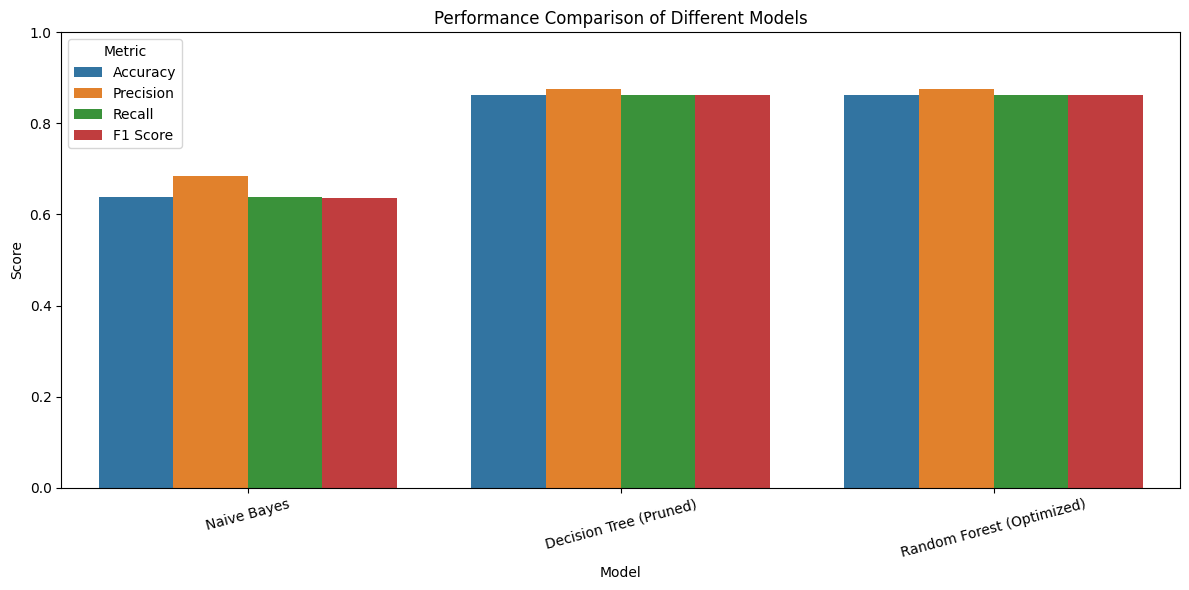

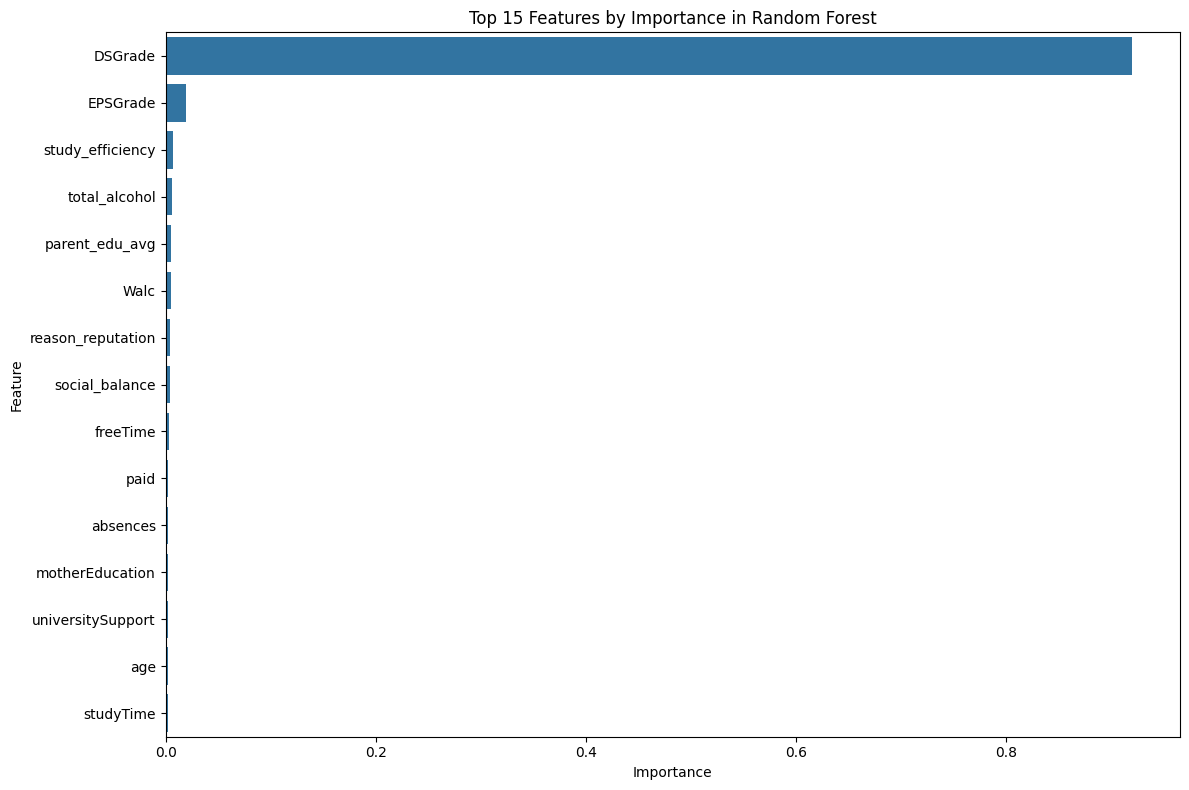


Top 10 Most Important Features in Random Forest:
              Feature  Importance
19            DSGrade    0.919254
18           EPSGrade    0.019402
25   study_efficiency    0.007205
27      total_alcohol    0.006011
29     parent_edu_avg    0.005313
16               Walc    0.004965
24  reason_reputation    0.004435
26     social_balance    0.004273
13           freeTime    0.002907
9                paid    0.002644


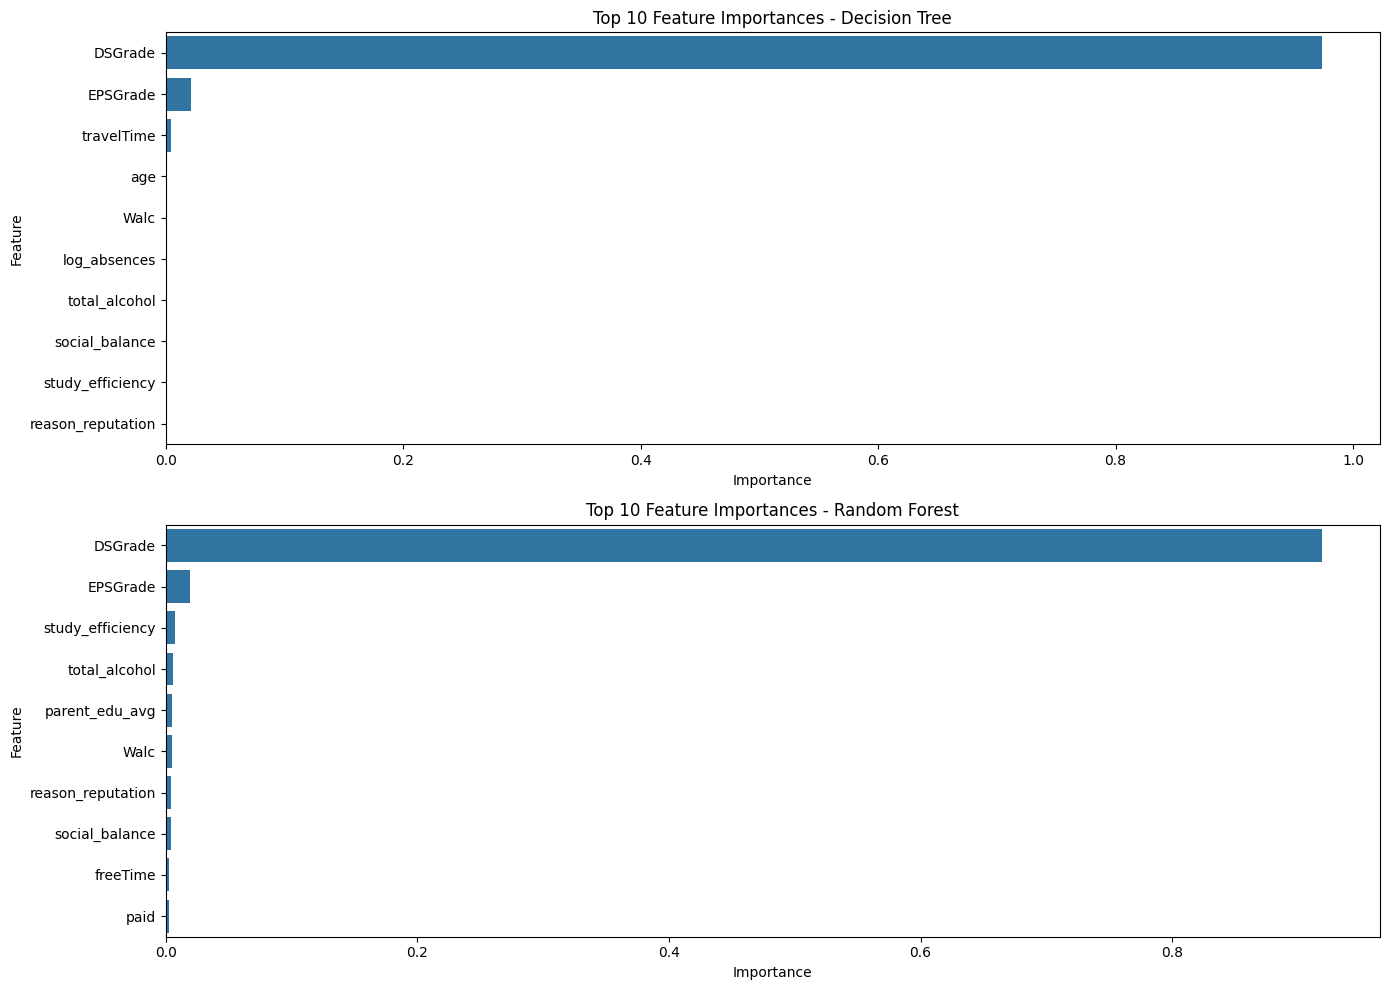


Number of features with zero importance in Random Forest: 3
Cross-Validation Scores: [0.90625    0.90625    0.84126984 0.85714286 0.84126984]
Mean CV Accuracy: 0.8704
Standard Deviation: 0.0298


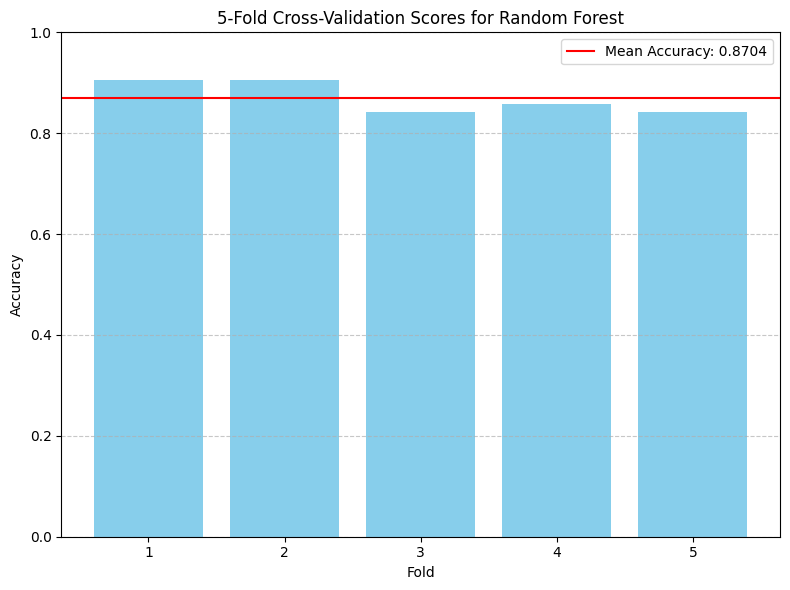

Per-Class Performance Metrics:
     Class  Precision    Recall  F1 Score  Support
0  Failing   0.862069  0.925926  0.892857       27
1  Group A   0.666667  1.000000  0.800000        4
2  Group B   1.000000  0.687500  0.814815       16
3  Group C   0.852941  0.878788  0.865672       33


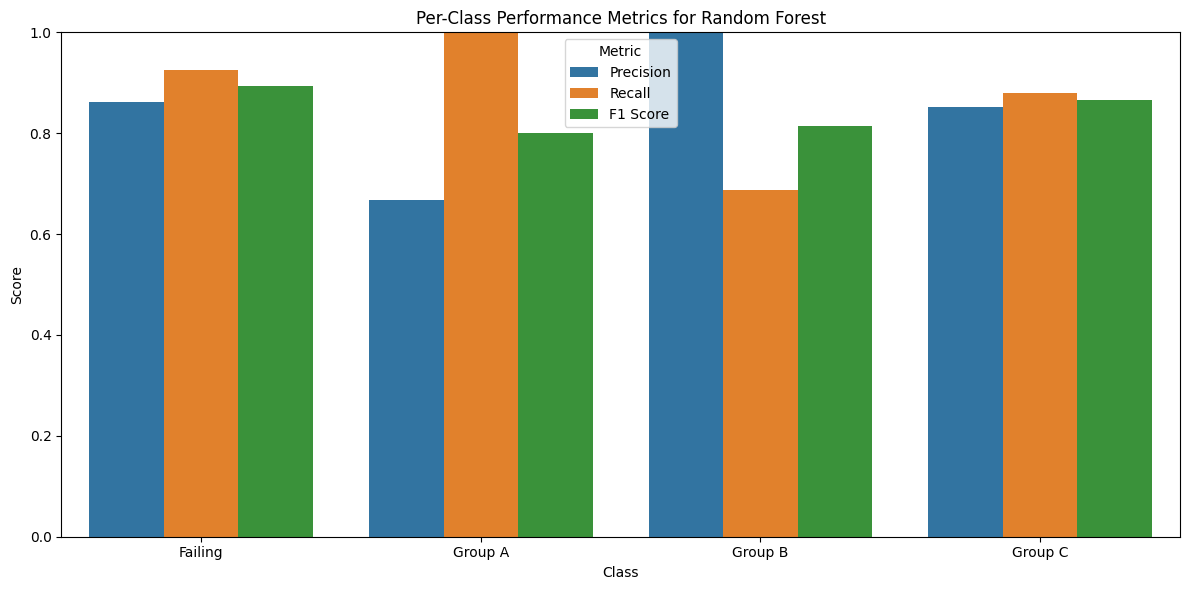

In [130]:
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train_engineered, y_train)

y_pred_rf = rf_classifier.predict(X_test_engineered)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Baseline Accuracy: {accuracy_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_classifier.classes_,
            yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.tight_layout()
plt.show()

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting RandomizedSearchCV...")
random_search.fit(X_train_engineered, y_train)
print("RandomizedSearchCV complete.")

best_params = random_search.best_params_
print("\nBest Parameters:", best_params)
best_rf_classifier = random_search.best_estimator_

y_pred_best_rf = best_rf_classifier.predict(X_test_engineered)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"\nOptimized Random Forest Accuracy: {accuracy_best_rf:.4f}")
print("\nClassification Report for Optimized Random Forest:")
print(classification_report(y_test, y_pred_best_rf))

conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_rf_classifier.classes_,
            yticklabels=best_rf_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Optimized Random Forest')
plt.tight_layout()
plt.show()

precision_rf = precision_score(y_test, y_pred_best_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_best_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_best_rf, average='weighted')

models = ['Naive Bayes', 'Decision Tree (Pruned)', 'Random Forest (Optimized)']
accuracies = [accuracy, accuracy_final, accuracy_best_rf]
precisions = [precision, precision_score(y_test, y_pred_final, average='weighted'), precision_rf]
recalls = [recall, recall_score(y_test, y_pred_final, average='weighted'), recall_rf]
f1_scores = [f1, f1_score(y_test, y_pred_final, average='weighted'), f1_rf]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print("Model Performance Comparison:")
print(comparison_df)

plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_data = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                            var_name='Metric', value_name='Score')

sns.barplot(data=comparison_data, x='Model', y='Score', hue='Metric')
plt.title('Performance Comparison of Different Models')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

rf_feature_importances = best_rf_classifier.feature_importances_
feature_names = X_train_engineered.columns

rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(15))
plt.title('Top 15 Features by Importance in Random Forest')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features in Random Forest:")
print(rf_importance_df.head(10))

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances - Decision Tree')

plt.subplot(2, 1, 2)
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(10))
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

zero_importance_rf = rf_importance_df[rf_importance_df['Importance'] == 0]
print(f"\nNumber of features with zero importance in Random Forest: {len(zero_importance_rf)}")

from sklearn.model_selection import cross_val_score

cv_rf = RandomForestClassifier(**best_params, random_state=42)

cv_scores = cross_val_score(cv_rf, X_train_engineered, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), cv_scores, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='-', label=f'Mean Accuracy: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores for Random Forest')
plt.xticks(range(1, 6))
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

class_precision, class_recall, class_f1, support = precision_recall_fscore_support(
    y_test, y_pred_best_rf, average=None, labels=best_rf_classifier.classes_
)

class_metrics = pd.DataFrame({
    'Class': best_rf_classifier.classes_,
    'Precision': class_precision,
    'Recall': class_recall,
    'F1 Score': class_f1,
    'Support': support
})

print("Per-Class Performance Metrics:")
print(class_metrics)

plt.figure(figsize=(12, 6))
class_metrics_melted = pd.melt(class_metrics, id_vars=['Class'], value_vars=['Precision', 'Recall', 'F1 Score'], 
                                var_name='Metric', value_name='Score')

sns.barplot(data=class_metrics_melted, x='Class', y='Score', hue='Metric')
plt.title('Per-Class Performance Metrics for Random Forest')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

XGBoost Baseline Accuracy: 0.9125

Classification Report:
              precision    recall  f1-score   support

     Failing       0.93      0.93      0.93        27
     Group A       0.80      1.00      0.89         4
     Group B       1.00      0.81      0.90        16
     Group C       0.89      0.94      0.91        33

    accuracy                           0.91        80
   macro avg       0.90      0.92      0.91        80
weighted avg       0.92      0.91      0.91        80



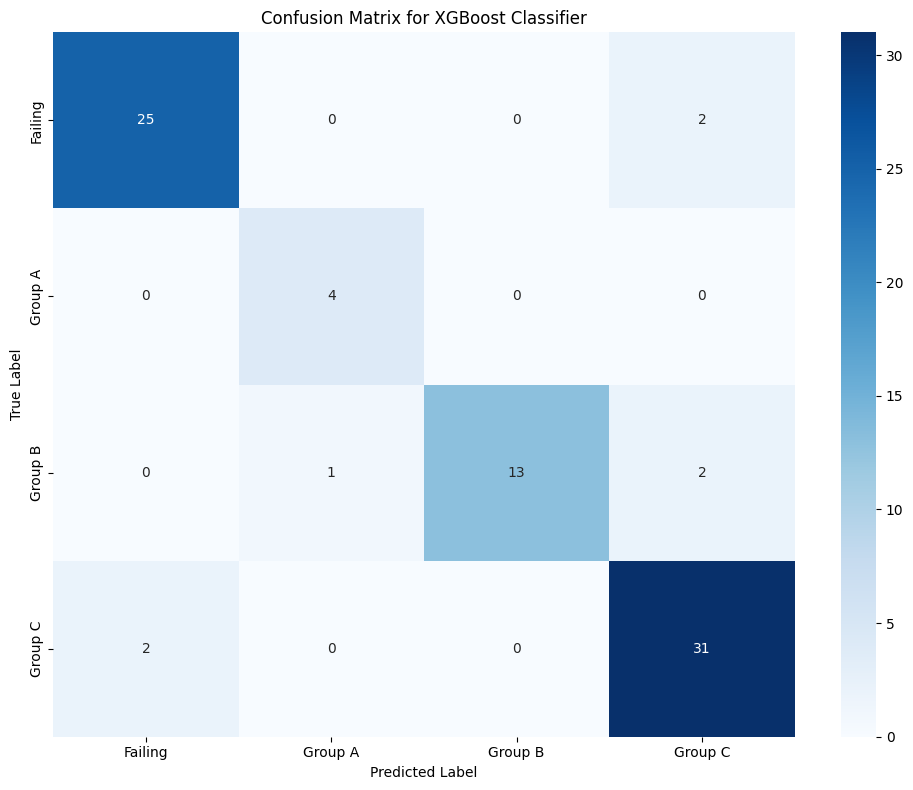

Starting manual parameter tuning...
Parameter tuning complete.

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 121, 'min_child_weight': 1, 'colsample_bytree': 0.8, 'subsample': 1.0}
Best Cross-Validation Score (mlogloss): 0.4079

Optimized XGBoost Accuracy: 0.8750

Classification Report for Optimized XGBoost:
              precision    recall  f1-score   support

     Failing       0.86      0.93      0.89        27
     Group A       0.75      0.75      0.75         4
     Group B       0.93      0.81      0.87        16
     Group C       0.88      0.88      0.88        33

    accuracy                           0.88        80
   macro avg       0.85      0.84      0.85        80
weighted avg       0.88      0.88      0.87        80



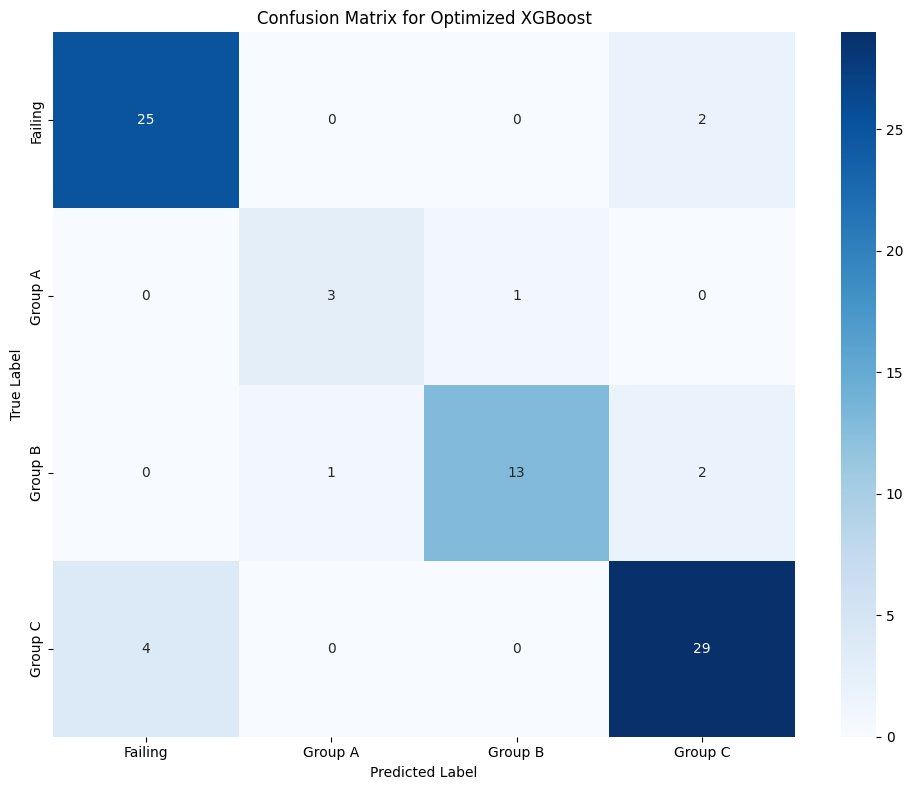

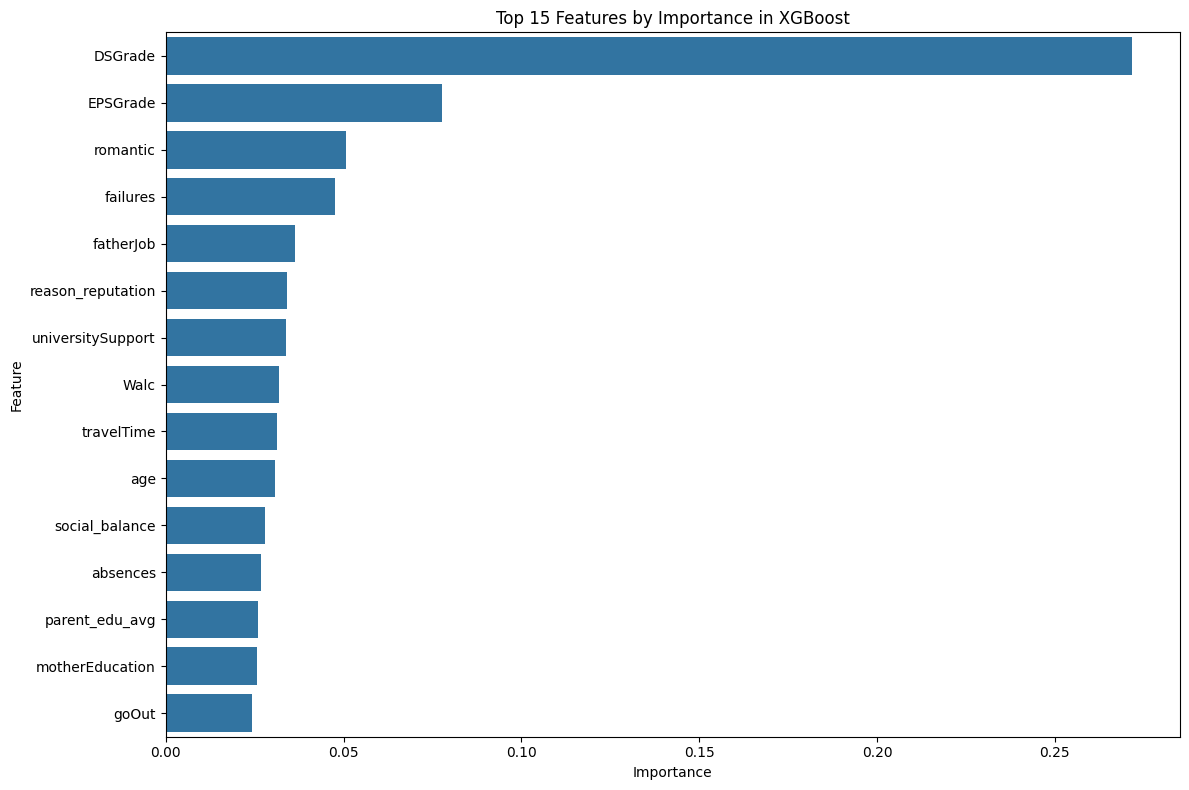


Top 10 Most Important Features in XGBoost:
              Feature  Importance
19            DSGrade    0.271583
18           EPSGrade    0.077550
12           romantic    0.050782
7            failures    0.047618
4           fatherJob    0.036311
24  reason_reputation    0.034169
8   universitySupport    0.033933
16               Walc    0.031764
5          travelTime    0.031269
0                 age    0.030811
Model Performance Comparison:
                       Model  Accuracy  Precision  Recall  F1 Score
0                Naive Bayes    0.6375   0.683942  0.6375  0.636208
1     Decision Tree (Pruned)    0.8625   0.876120  0.8625  0.861392
2  Random Forest (Optimized)    0.8625   0.876120  0.8625  0.861392
3        XGBoost (Optimized)    0.8750   0.876663  0.8750  0.874673


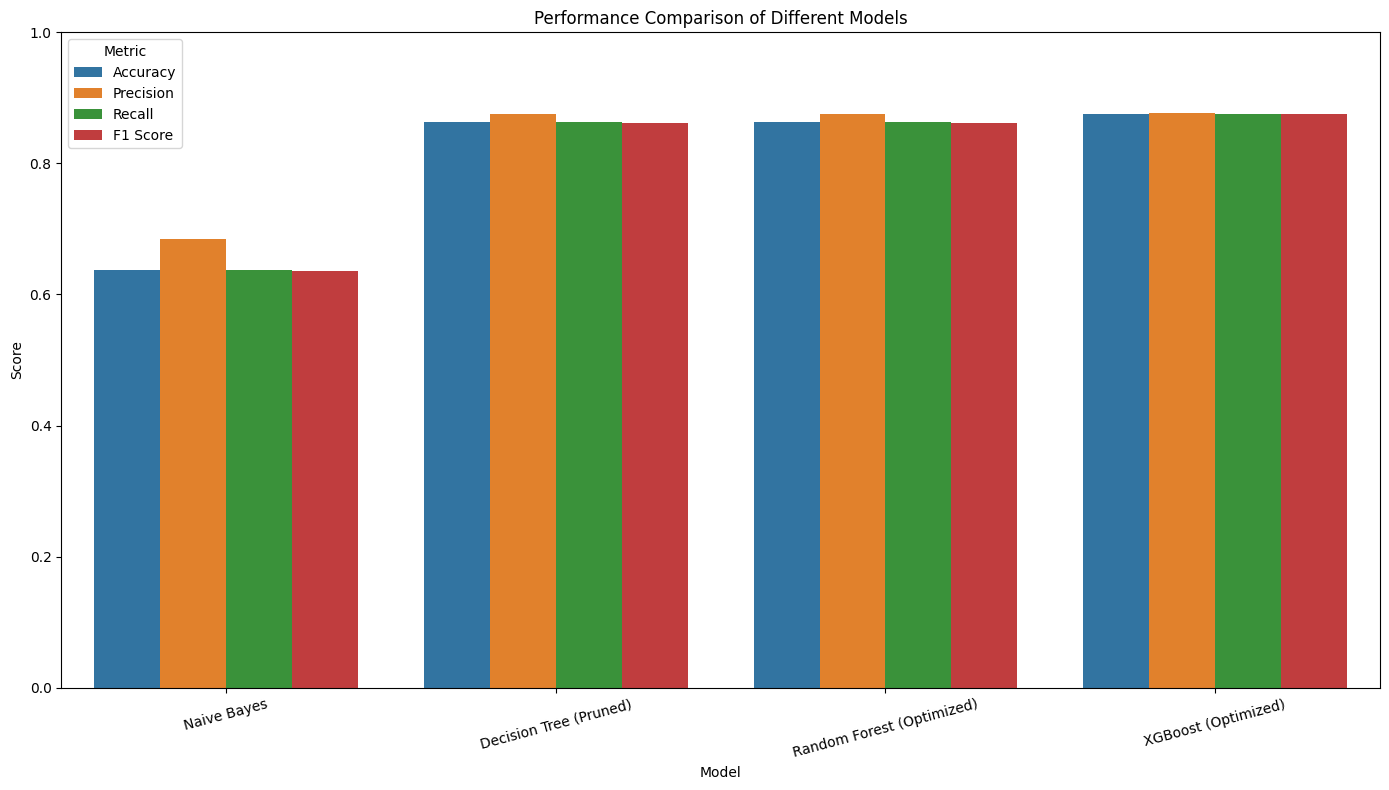

Per-Class Performance Metrics for XGBoost:
     Class  Precision    Recall  F1 Score  Support
0  Failing   0.862069  0.925926  0.892857       27
1  Group A   0.750000  0.750000  0.750000        4
2  Group B   0.928571  0.812500  0.866667       16
3  Group C   0.878788  0.878788  0.878788       33


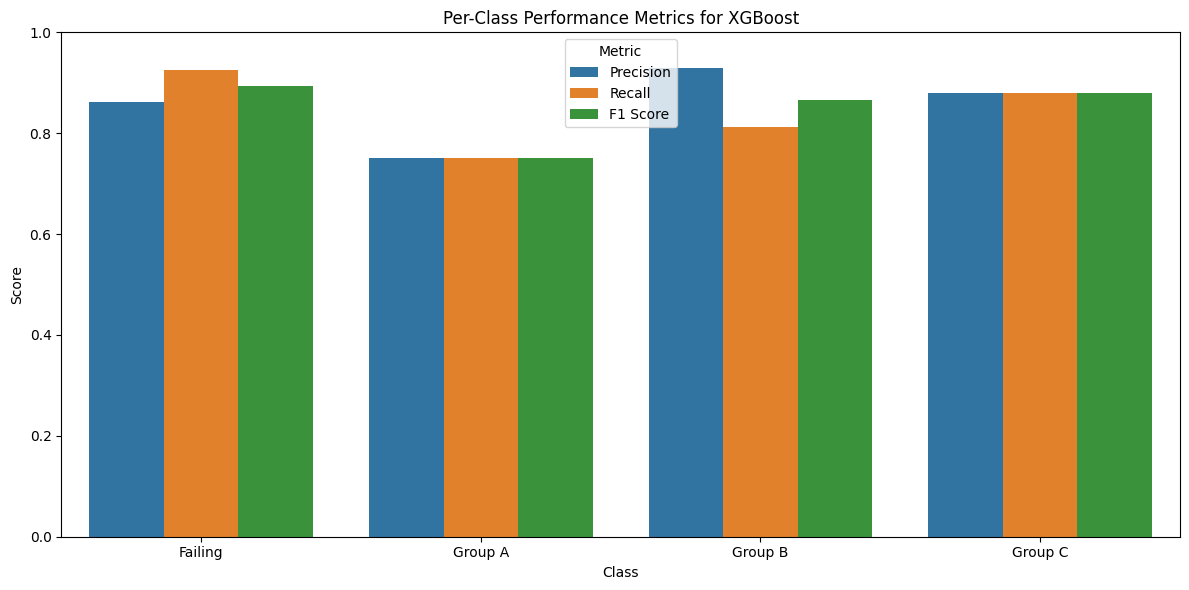

Performing cross-validation for XGBoost...


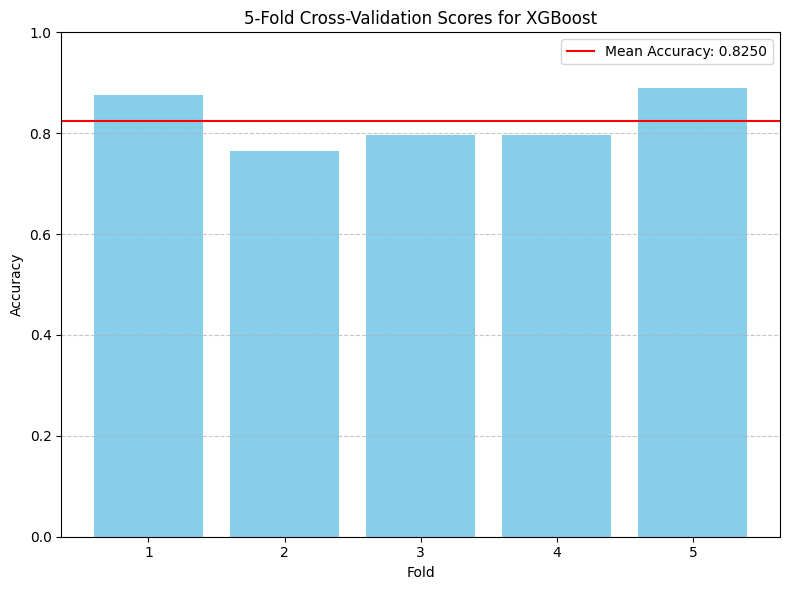

In [131]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)

y_test_encoded = le.transform(y_test)

xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42
)

xgb_classifier.fit(X_train_engineered, y_train_encoded)

y_pred_encoded = xgb_classifier.predict(X_test_engineered)

y_pred_xgb = le.inverse_transform(y_pred_encoded)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Baseline Accuracy: {accuracy_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.tight_layout()
plt.show()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'subsample': [0.8, 1.0]
}

print("Starting manual parameter tuning...")
best_score = 0
best_params = {}
results = []

dtrain = xgb.DMatrix(X_train_engineered, label=y_train_encoded)

param_combinations = [
    {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'min_child_weight': 1, 'colsample_bytree': 0.8, 'subsample': 0.8},
    {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'min_child_weight': 3, 'colsample_bytree': 0.7, 'subsample': 0.8},
    {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'min_child_weight': 5, 'colsample_bytree': 1.0, 'subsample': 1.0},
    {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'min_child_weight': 3, 'colsample_bytree': 1.0, 'subsample': 0.8},
    {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'min_child_weight': 1, 'colsample_bytree': 0.8, 'subsample': 1.0}
]

for params in param_combinations:
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'seed': 42,
        'eta': params['learning_rate'],
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'],
        'colsample_bytree': params['colsample_bytree'],
        'subsample': params['subsample']
    }
    
    cv_results = xgb.cv(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators'],
        nfold=5,
        metrics='mlogloss',
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    mean_score = cv_results['test-mlogloss-mean'].min()
    best_iteration = cv_results['test-mlogloss-mean'].argmin() + 1
    
    results.append({
        'params': params,
        'mean_score': mean_score,
        'best_iteration': best_iteration
    })
    
    if best_score == 0 or mean_score < best_score:
        best_score = mean_score
        best_params = params.copy()
        best_params['n_estimators'] = best_iteration

print("Parameter tuning complete.")
print("\nBest Parameters:", best_params)
print(f"Best Cross-Validation Score (mlogloss): {best_score:.4f}")

best_xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample']
)

best_xgb_classifier.fit(X_train_engineered, y_train_encoded)

y_pred_best_encoded = best_xgb_classifier.predict(X_test_engineered)
y_pred_best_xgb = le.inverse_transform(y_pred_best_encoded)

accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"\nOptimized XGBoost Accuracy: {accuracy_best_xgb:.4f}")
print("\nClassification Report for Optimized XGBoost:")
print(classification_report(y_test, y_pred_best_xgb))

conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Optimized XGBoost')
plt.tight_layout()
plt.show()

xgb_feature_importances = best_xgb_classifier.feature_importances_
feature_names = X_train_engineered.columns

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(15))
plt.title('Top 15 Features by Importance in XGBoost')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features in XGBoost:")
print(xgb_importance_df.head(10))

precision_xgb = precision_score(y_test, y_pred_best_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_best_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_best_xgb, average='weighted')

models = ['Naive Bayes', 'Decision Tree (Pruned)', 'Random Forest (Optimized)', 'XGBoost (Optimized)']
accuracies = [accuracy, accuracy_final, accuracy_best_rf, accuracy_best_xgb]
precisions = [precision, precision_score(y_test, y_pred_final, average='weighted'), precision_rf, precision_xgb]
recalls = [recall, recall_score(y_test, y_pred_final, average='weighted'), recall_rf, recall_xgb]
f1_scores = [f1, f1_score(y_test, y_pred_final, average='weighted'), f1_rf, f1_xgb]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print("Model Performance Comparison:")
print(comparison_df)

plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_data = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                        var_name='Metric', value_name='Score')

sns.barplot(data=comparison_data, x='Model', y='Score', hue='Metric')
plt.title('Performance Comparison of Different Models')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


class_precision_xgb, class_recall_xgb, class_f1_xgb, support_xgb = precision_recall_fscore_support(
    y_test, y_pred_best_xgb, average=None, labels=le.classes_
)

class_metrics_xgb = pd.DataFrame({
    'Class': le.classes_,
    'Precision': class_precision_xgb,
    'Recall': class_recall_xgb,
    'F1 Score': class_f1_xgb,
    'Support': support_xgb
})

print("Per-Class Performance Metrics for XGBoost:")
print(class_metrics_xgb)

plt.figure(figsize=(12, 6))
class_metrics_melted_xgb = pd.melt(class_metrics_xgb, id_vars=['Class'], value_vars=['Precision', 'Recall', 'F1 Score'], 
                                var_name='Metric', value_name='Score')

sns.barplot(data=class_metrics_melted_xgb, x='Class', y='Score', hue='Metric')
plt.title('Per-Class Performance Metrics for XGBoost')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    **best_params
)

print("Performing cross-validation for XGBoost...")
cv_scores = []
cv_folds = 5
for i in range(cv_folds):
    X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(
        X_train_engineered, y_train_encoded, 
        test_size=0.2, 
        random_state=42+i,
        stratify=y_train_encoded
    )
    
    xgb_model.fit(X_train_cv, y_train_cv)
    
    score = accuracy_score(y_test_cv, xgb_model.predict(X_test_cv))
    cv_scores.append(score)

plt.figure(figsize=(8, 6))
plt.bar(range(1, cv_folds+1), cv_scores, color='skyblue')
plt.axhline(y=np.mean(cv_scores), color='red', linestyle='-', 
            label=f'Mean Accuracy: {np.mean(cv_scores):.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores for XGBoost')
plt.xticks(range(1, cv_folds+1))
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [132]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeFromScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None
        
    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))
    
    def _information_gain(self, X, y, feature_idx, threshold):
        parent_entropy = self._entropy(y)
        
        left_mask = X[:, feature_idx] < threshold
        right_mask = ~left_mask
        
        n_samples = len(y)
        n_left = sum(left_mask)
        n_right = sum(right_mask)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        entropy_left = self._entropy(y[left_mask])
        entropy_right = self._entropy(y[right_mask])
        
        child_entropy = (n_left / n_samples) * entropy_left + (n_right / n_samples) * entropy_right
        
        return parent_entropy - child_entropy
    
    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        
        if len(np.unique(y)) == 1:
            return None, None
        
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature_idx, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or len(np.unique(y)) == 1:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        left_mask = X[:, best_feature] < best_threshold
        right_mask = ~left_mask
        
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] < node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        X = np.array(X)
        y_pred = [self._predict_sample(x, self.root) for x in X]
        return np.array(y_pred)

Converting categorical labels to numeric for custom implementation...
Label mapping: {'Failing': 0, 'Group A': 1, 'Group B': 2, 'Group C': 3}

Training custom decision tree...

Training scikit-learn decision tree...

=== Performance Comparison ===
Custom Decision Tree Accuracy: 0.8625
Scikit-learn Decision Tree Accuracy: 0.8625

Custom Training Time: 0.1363 seconds
Scikit-learn Training Time: 0.0148 seconds

Custom Prediction Time: 0.0000 seconds
Scikit-learn Prediction Time: 0.0000 seconds

=== Custom Decision Tree Classification Report ===
              precision    recall  f1-score   support

     Failing       0.86      0.93      0.89        27
     Group A       0.67      1.00      0.80         4
     Group B       1.00      0.69      0.81        16
     Group C       0.85      0.88      0.87        33

    accuracy                           0.86        80
   macro avg       0.85      0.87      0.84        80
weighted avg       0.88      0.86      0.86        80


=== Scikit-learn

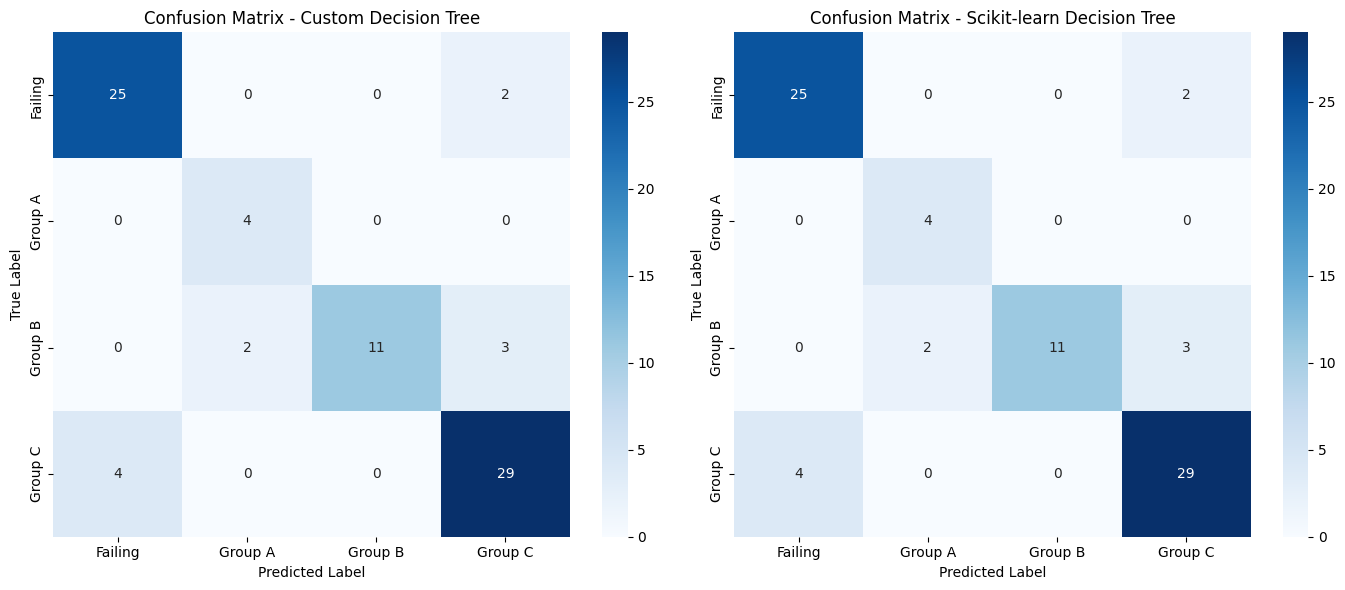


Comparing performance across different tree depths...

Training with depth = 1

Training with depth = 2

Training with depth = 3

Training with depth = 5

Training with depth = 7

Training with depth = 10

Training with depth = None (unlimited)


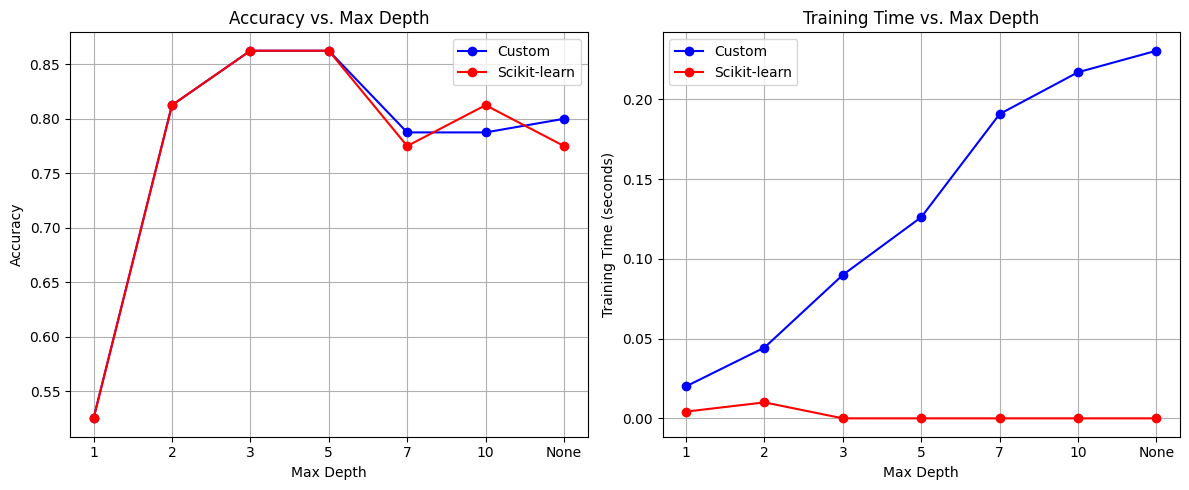

In [ ]:
print("Converting categorical labels to numeric for custom implementation...")
label_mapping = {label: i for i, label in enumerate(sorted(y_train.unique()))}
y_train_numeric = y_train.map(label_mapping)
y_test_numeric = y_test.map(label_mapping)

print("Label mapping:", label_mapping)

print("\nTraining custom decision tree...")
start_time = time.time()
custom_dt = DecisionTreeFromScratch(max_depth=5)
custom_dt.fit(X_train_engineered.to_numpy(), y_train_numeric.to_numpy())
custom_train_time = time.time() - start_time

start_time = time.time()
y_pred_custom = custom_dt.predict(X_test_engineered.to_numpy())
custom_predict_time = time.time() - start_time

y_pred_custom_mapped = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in y_pred_custom])

print("\nTraining scikit-learn decision tree...")
start_time = time.time()
sklearn_dt = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
sklearn_dt.fit(X_train_engineered, y_train)
sklearn_train_time = time.time() - start_time

start_time = time.time()
y_pred_sklearn = sklearn_dt.predict(X_test_engineered)
sklearn_predict_time = time.time() - start_time

custom_accuracy = accuracy_score(y_test, y_pred_custom_mapped)
sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)

print("\n=== Performance Comparison ===")
print(f"Custom Decision Tree Accuracy: {custom_accuracy:.4f}")
print(f"Scikit-learn Decision Tree Accuracy: {sklearn_accuracy:.4f}")
print(f"\nCustom Training Time: {custom_train_time:.4f} seconds")
print(f"Scikit-learn Training Time: {sklearn_train_time:.4f} seconds")
print(f"\nCustom Prediction Time: {custom_predict_time:.4f} seconds")
print(f"Scikit-learn Prediction Time: {sklearn_predict_time:.4f} seconds")

print("\n=== Custom Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_custom_mapped))

print("\n=== Scikit-learn Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_sklearn))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom_mapped)
sns.heatmap(conf_matrix_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_train.unique()),
            yticklabels=sorted(y_train.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom Decision Tree')

plt.subplot(1, 2, 2)
conf_matrix_sklearn = confusion_matrix(y_test, y_pred_sklearn)
sns.heatmap(conf_matrix_sklearn, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_train.unique()),
            yticklabels=sorted(y_train.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Scikit-learn Decision Tree')

plt.tight_layout()
plt.show()

depths = [1, 2, 3, 5, 7, 10, None]
custom_accuracies = []
sklearn_accuracies = []
custom_train_times = []
sklearn_train_times = []

print("\nComparing performance across different tree depths...")
for depth in depths:
    depth_str = str(depth) if depth is not None else "None (unlimited)"
    print(f"\nTraining with depth = {depth_str}")
    
    start_time = time.time()
    custom_dt = DecisionTreeFromScratch(max_depth=depth)
    custom_dt.fit(X_train_engineered.to_numpy(), y_train_numeric.to_numpy())
    custom_train_time = time.time() - start_time
    y_pred_custom = custom_dt.predict(X_test_engineered.to_numpy())
    y_pred_custom_mapped = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in y_pred_custom])
    custom_accuracy = accuracy_score(y_test, y_pred_custom_mapped)
    
    start_time = time.time()
    sklearn_dt = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42, ccp_alpha = 0)
    sklearn_dt.fit(X_train_engineered, y_train)
    sklearn_train_time = time.time() - start_time
    y_pred_sklearn = sklearn_dt.predict(X_test_engineered)
    sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
    
    custom_accuracies.append(custom_accuracy)
    sklearn_accuracies.append(sklearn_accuracy)
    custom_train_times.append(custom_train_time)
    sklearn_train_times.append(sklearn_train_time)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
depth_labels = [str(d) if d is not None else "None" for d in depths]
plt.plot(depth_labels, custom_accuracies, 'b-o', label='Custom')
plt.plot(depth_labels, sklearn_accuracies, 'r-o', label='Scikit-learn')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(depth_labels, custom_train_times, 'b-o', label='Custom')
plt.plot(depth_labels, sklearn_train_times, 'r-o', label='Scikit-learn')
plt.xlabel('Max Depth')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Max Depth')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()